# Intro to SMACT
 by Anthony Onwuli

**Semiconducting Materials from Analogy and Chemical Theory** (SMACT) is a one of our python packages which relies on information about the chemical elements and their various species to develop and implement a range of screening functions.


## Motivation for the package


* Materials discovery relies on the need to go beyond our knowledge of existing materials. 
* The known materials only make up a tiny part of the search space of new materials.

* smact can be used to generate elemental combinations which are then screened using filters

## The core of SMACT - the element and species classes

For demo purposes we will show of the element and species classes.

In [1]:
### Imports
import smact
from smact import Element, Species, element_dictionary, ordered_elements, neutral_ratios
from smact.screening import smact_filter, pauling_test
from datetime import datetime
import itertools
import multiprocessing
import pandas as pd
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer

Let's consider iron (Fe).

In [2]:
Fe=smact.Element("Fe")

Using smact we can check what oxidation states are accessible to a particular atom.

In [3]:
Fe.oxidation_states

[-2, -1, 1, 2, 3, 4, 5, 6]

The default oxidation states considered by smact are meant to be as exhaustive as possible.

In [4]:
print(f"The oxidation states that are recognised by the pymatgen structure predictor are {Fe.oxidation_states_sp}")

The oxidation states that are recognised by the pymatgen structure predictor are [2, 3, 4, 5, 6]


We can check other properties of the atom including, but not limited to:
* Atomic number
* Pauling electronegativitty
* Ionisation potential
* coordination environments
* covalent radius
* molar mass
* Hirfindahl-Hirschman Index

In [5]:
print(f"The atomic number of Fe is {Fe.number}")
print(f"The pauling electronegativity of Fe is {Fe.pauling_eneg}")
print(f"The Ionisation potential of Fe is {Fe.ionpot}")
print(f"The available coordination environments of Fe are {Fe.coord_envs}")
print(f"The covalent radius of Fe is {Fe.covalent_radius}")
print(f"The molar mass of Fe is {Fe.mass}")
print(f"The Hirfindahl-Hirschman Index for elemental reserves of Fe is {Fe.HHI_r}")

The atomic number of Fe is 26.0
The pauling electronegativity of Fe is 1.83
The Ionisation potential of Fe is 7.9024678
The available coordination environments of Fe are ['4_n', '4_sq', '6_n', '8_n', '4_n', '5_n', '6_n', '8_n', '6_n', '4_n']
The covalent radius of Fe is 1.32
The molar mass of Fe is 55.845
The Hirfindahl-Hirschman Index for elemental reserves of Fe is 1400.0


Defining a species in smact requires us to decide on the oxidation state and the coordination environment of the ion.
Let's consider Fe<sup>2+</sup> in an octahedral coordination

In [6]:
Fe2=smact.Species("Fe", 2, coordination=6)

Similar to the Element class, we can access a few properties

In [7]:
print(f"The oxidation state of this species is {Fe2.oxidation}")
print(f"The coordination of this Fe ion is {Fe2.coordination}")
print(f"The shannon radius of Fe2+ in an octahedral position is {Fe2.shannon_radius}")

The oxidation state of this species is 2
The coordination of this Fe ion is 6
The shannon radius of Fe2+ in an octahedral position is 0.84


## Generating compositions for a chosen search-space

Let's do a short demo of using SMACT to generate a list of elemental compositions which could be used as an input for some screening workflows.

In this example, we'll consider lithium oxide garnets - A<sub>3</sub>B<sub>2</sub>Li<sub>3</sub>O<sub>12</sub>

### List generation

In [8]:
#Generate the dictionary of elements
#We'll only consider the first 83 elements

all_el=element_dictionary(elements=ordered_elements(1,83)) #A dictionary of all element objects
symbols_list=list(all_el.keys())
all_els=[all_el[symbol] for symbol in symbols_list]

#Let's remove the elements we don't want to consider
dont_want=["He","Ne","Ar","Kr","Xe","Pm","Tc"]

for unwanted in dont_want:
    symbols_list.remove(unwanted)
all_els=[all_el[symbol] for symbol in symbols_list]
coord_els=[el.coord_envs for el in all_els]

We'll investigate A-B-Li-O elemental combinations. As some experimental materials do have the same ion occupying different coordination sites in the garnet structure, we'll allow consideration of a composition having less than 4 unique elements.

In [9]:
#Coordination environments to consider

#A requires elements which can take a coordination state of 8
#B requires elements which can take a coordination state of 6
A_els=[]
B_els=[]

for el in all_els:
    if el.coord_envs==None:
        continue
    CNs=[i.split("_")[0] for i in el.coord_envs]
    if "8" in CNs:
        A_els.append(el)
    if "6" in CNs:
        B_els.append(el)

# Elements for C and D
C_list=["Li"]
D_list = ["O"]
C_els=[all_el[symbol] for symbol in C_list]
D_els=[all_el[symbol] for symbol in D_list]

print(f"The number of  allowed elements for (A) are: {len(A_els)} \n" )
print("The number of allowed elements for {B} are:" f"{len(B_els)} \n" )
        

The number of  allowed elements for (A) are: 45 

The number of allowed elements for {B} are:75 



In [10]:
#Generate the A-B-C-D combinations

ABCD_pairs = [(x,y,z,a) for x in A_els for y in B_els for z in C_els for a in D_els]

# Prove to ourselves that we have all unique chemical systems
print(f"We have generated {len(ABCD_pairs)} potential compounds")

#for i in oxide_systems:
 #   print(f"{i[0].symbol} {i[1].symbol} {i[2].symbol} {i[3].symbol}")

We have generated 3375 potential compounds


In [11]:
def smact_filter(els, stoichs=[[3],[2],[3], [12]], species_unique=True):

    compositions = []

    # Get symbols and electronegativities
    symbols = tuple(e.symbol for e in els)
    electronegs = [e.pauling_eneg for e in els]
    ox_combos = [e.oxidation_states for e in els]
    for ox_states in itertools.product(*ox_combos):
        # Test for charge balance
        cn_e, cn_r = neutral_ratios(ox_states, stoichs=stoichs)
        # Electronegativity test
        if cn_e:
            electroneg_OK = pauling_test(ox_states, electronegs)
            if electroneg_OK:
                for ratio in cn_r:
                    compositions.append(tuple([symbols,ox_states,ratio]))

    # Return list depending on whether we are interested in unique species combinations
    # or just unique element combinations.
    if species_unique:
        return(compositions)
    else:
        compositions = [(i[0], i[2]) for i in compositions]
        compositions = list(set(compositions))
        return compositions

In [12]:
# Use multiprocessing and smact_filter to quickly generate our list of compositions
start = datetime.now()
if __name__ == '__main__':   # Always use pool protected in an if statement 
    with multiprocessing.Pool(processes=4) as p:    # start 4 worker processes
        result = p.map(smact_filter, ABCD_pairs)
print('Time taken to generate list:  {0}'.format(datetime.now()-start))

Time taken to generate list:  0:00:00.128837


In [13]:
# Flatten the list of lists
flat_list = [item for sublist in result for item in sublist]
print('Number of compositions: --> {0} <--'.format(len(flat_list)))
print('Each list entry looks like this:\n  elements, oxidation states, stoichiometries')
for i in flat_list[:5]:
    print(i)

Number of compositions: --> 2512 <--
Each list entry looks like this:
  elements, oxidation states, stoichiometries
(('Li', 'B', 'Li', 'O'), (1, 3, 1, -1), (3, 2, 3, 12))
(('Li', 'C', 'Li', 'O'), (1, 3, 1, -1), (3, 2, 3, 12))
(('Li', 'N', 'Li', 'O'), (1, 3, 1, -1), (3, 2, 3, 12))
(('Li', 'Al', 'Li', 'O'), (1, 3, 1, -1), (3, 2, 3, 12))
(('Li', 'Si', 'Li', 'O'), (1, 3, 1, -1), (3, 2, 3, 12))


### Pymatgen reduced formulas

In [14]:
from pymatgen.core import Composition
def comp_maker(comp):
    form = []
    for el, ammt in zip(comp[0], comp[2]):
        form.append(el)
        form.append(ammt)
    form = ''.join(str(e) for e in form)
    pmg_form = Composition(form).reduced_formula
    return pmg_form

if __name__ == '__main__':  
    with multiprocessing.Pool(processes=4) as p:
        pretty_formulas = p.map(comp_maker, flat_list)

print('Each list entry now looks like this: ')
for i in pretty_formulas[:5]:
    print(i)

Each list entry now looks like this: 
Li3BO6
Li3CO6
Li3NO6
Li3AlO6
Li3SiO6


In [15]:
#Calculate sustainability
def sus_calc(comp):
    sus_factor = 0
    for i in Composition(comp).elements:
        sus_factor += (Composition(comp).get_wt_fraction(i) *smact.Element(i.symbol).HHI_r)
    return sus_factor

#Compute sustainability
start = datetime.now()
if __name__ == '__main__':  
    with multiprocessing.Pool(processes=4) as p:
        sus_factors = p.map(sus_calc, pretty_formulas)
#sus_factors=[sus_calc(Composition(i)) for i in pretty_formulas]
print(f'Time taken to calculate sus factors:  {datetime.now()-start}')



Time taken to calculate sus factors:  0:00:01.972532


In [16]:
#We want to be able to feed in a list of species into a structure predictor
#Need to our list in the form of [(A,x), (B,y), (C,z)]
#Where A,B,C are species, dtype-string
#x,y,z are the charges/oxidation state - dtype: int
from smact.structure_prediction.utilities import parse_spec, unparse_spec
species=[]
A=[]
B=[]
C=[]
D=[]
for i in range(len(flat_list)):
    species.append(pretty_formulas[i])
    A.append((unparse_spec((flat_list[i][0][0],flat_list[i][1][0]))))
    B.append((unparse_spec((flat_list[i][0][1],flat_list[i][1][1]))))
    C.append((unparse_spec((flat_list[i][0][2],flat_list[i][1][2]))))
    D.append((unparse_spec((flat_list[i][0][3],flat_list[i][1][3]))))


In [17]:
columns=["Pretty Formula","A","B","C","D"]
df_list=[[species[i], A[i], B[i], C[i], D[i]] for i in range(len(species))]
df=pd.DataFrame(data=df_list, columns=columns)
df["sus_factor"]=sus_factors
df=df.sort_values(by='sus_factor', ascending=True)
df=df.reset_index(drop=True)

df.head()


,Pretty Formula,A,B,C,D,sus_factor
0,Li3Mg3(NO6)2,Mg1+,N3+,Li1+,O1-,745.566611
1,Na3Li3(NO6)2,Na1+,N3+,Li1+,O1-,748.694226
2,Li3Mg3(CO6)2,Mg1+,C3+,Li1+,O1-,748.731405
3,Na3Li3(CO6)2,Na1+,C3+,Li1+,O1-,751.940682
4,Li3Mg3Al2O12,Mg1+,Al3+,Li1+,O1-,806.236425


### Tolerance factor calculation

In [18]:
def tol_factor_calc (A, B,C, D):
    """Function calculates the tolerance factor for a garnet compound
    
    Args:
        A (Species): Ion with coordination = 8
        B (Species): Ion with coordination = 6
        C (Species): Ion with coordination = 4
        D (Species): Ion with coordination = 4
        
    Returns:
        tol_factor (float): The tolerance factor"""
    
    #Create a check to see if the species exists
    if any([A.shannon_radius==None,B.shannon_radius==None, C.shannon_radius==None, D.shannon_radius==None]):
        #If check passed, calculate the tolerance factor
        tau=0
    else:
        arg=(B.shannon_radius +D.shannon_radius)**2 - (4/9)*(A.shannon_radius + D.shannon_radius)**2
        if arg<0:
            tau=0
        else:
            tau=3*(arg**0.5)/(2*(C.shannon_radius + D.shannon_radius))

    #Create a list of symbols, oxidation states and tolerance factor
    return tau

In [19]:
row_list=[]
#iterate over row
for index, rows in df.iterrows():
    #Species conversion
    s1, n1 = parse_spec(rows.A)[0], parse_spec(rows.A)[1]
    s2, n2 = parse_spec(rows.B)[0], parse_spec(rows.B)[1]
    s3, n3 = parse_spec(rows.C)[0], parse_spec(rows.C)[1]
    s4, n4 = parse_spec(rows.D)[0], parse_spec(rows.D)[1]
    
    A=Species(s1,n1, coordination=8)
    B=Species(s2,n2, coordination=6)
    C=Species(s3,n3, coordination=4)
    D=Species(s4,n4, coordination=4)
    
    #Create list for the current row
    
    my_list=[rows["Pretty Formula"], rows.A, rows.B, rows.C, rows.D, tol_factor_calc(A,B,C,D)]
    
    #append to the list
    row_list.append(my_list)

In [20]:
garnet_tol_list=[]
for i in row_list:
    if i[5]!=0:
        garnet_tol_list.append(i)
garnet_tol_list[:5]


[['Li3Fe3(SO6)2', 'Fe3+', 'S6+', 'Li1+', 'O2-', 0.6439752040959554],
 ['Li3Fe3(SeO6)2', 'Fe3+', 'Se6+', 'Li1+', 'O2-', 0.8223350253807107],
 ['Li3In3(SO6)2', 'In3+', 'S6+', 'Li1+', 'O2-', 0.5037991151279656],
 ['Li3Cr3(AuO6)2', 'Cr5+', 'Au3+', 'Li1+', 'O2-', 1.379602141600136],
 ['Li3In3(SeO6)2', 'In3+', 'Se6+', 'Li1+', 'O2-', 0.7178749047579167]]

In [21]:
print(f"By considering the coordination states, we have reduced our search space from {len(row_list)} to {len(garnet_tol_list)}")

By considering the coordination states, we have reduced our search space from 2512 to 282


In [22]:
filtered_tol_list=[]

for i in garnet_tol_list:
    if i[5]<=1.333 and i[5]>=0.748:
        filtered_tol_list.append(i)
filtered_tol_list[:5]
        

[['Li3Fe3(SeO6)2', 'Fe3+', 'Se6+', 'Li1+', 'O2-', 0.8223350253807107],
 ['Li3Cr2(FeO4)3', 'Fe3+', 'Cr6+', 'Li1+', 'O2-', 0.8474725326686208],
 ['Li3Cr3(AgO6)2', 'Cr5+', 'Ag3+', 'Li1+', 'O2-', 1.2847278510511317],
 ['Li3Cr3(FeO6)2', 'Cr5+', 'Fe3+', 'Li1+', 'O2-', 1.137146479345856],
 ['Li3Cr3(CuO6)2', 'Cr5+', 'Cu3+', 'Li1+', 'O2-', 1.0758427895135063]]

In [23]:
print(f"By considering the the stability range for the tolerance factor, we have reduced our search space from {len(garnet_tol_list)} to {len(filtered_tol_list)}")

By considering the the stability range for the tolerance factor, we have reduced our search space from 282 to 165


# Structure Prediction
The previous example of using a tolerance factor to estimate the search space for a particular crystal structure system. 
What if we wanted perform this task in absence of a tolerance factor?

The structure prediction module contains the following submodules
* Prediction
* Database
* Mutation
* Structure
* Substitution Probability models
* Utilities

Estimating the Li7 garnet search space

In [24]:
from smact.structure_prediction import prediction, database, mutation, probability_models, structure, utilities
import json
import itertools
from itertools import zip_longest
import smact

# An optional utility to display a progress bar
# for long-running loops. `pip install tqdm`.
from tqdm import tqdm



## Creating a SMACT Database

In [25]:
#Import modules
from pymatgen.ext.matproj import MPRester
from pprint import pprint
from pymatgen.analysis import structure_matcher
import pandas as pd

#Use the API Key
m = MPRester()
data = m.query("Li7*3*2O12", properties=["pretty_formula","material_id","spacegroup.symbol","icsd_ids","e_above_hull","exp","structure"])
len(data)


/home/aonw/anaconda3/envs/structure_prediction_test_env/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/aonw/anaconda3/envs/structure_prediction_test_env/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/aonw/anaconda3/envs/structure_prediction_test_env/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/aonw/anaconda3/envs/structure_prediction_test_env/lib/python3.8/site-packages/pymatgen/core/perio

238

In [28]:
#get structure of LLZO
SM=structure_matcher.StructureMatcher()

LLZO=m.query("mp-942733", properties=["pretty_formula","material_id","spacegroup.symbol","icsd_ids","e_above_hull","exp","structure"])
LLZO_structure=LLZO[0]["structure"]

#Sort database results into experimental and theoretical
experimental_list=[]
theoretical_list=[]
for i in data:
    if len(i["icsd_ids"])!=0:
        experimental_list.append(i)
    else:
        theoretical_list.append(i)
print(f"Of the 238 materials from the query, {len(experimental_list)} had experimental structures")
print(f"Of the 238 materials from the query, {len(theoretical_list)} had theoretical structures")

print("")
#Iterate over query data and verify if they have the correct structure

t_garnet_data=[]
e_garnet_data=[]
for i in theoretical_list:
    if SM.fit_anonymous(i['structure'], LLZO_structure):
        t_garnet_data.append(i)
print(f"Of the 234 theoretical materials from the query, {len(t_garnet_data)} structures matched LLZO")

for i in experimental_list:
    if SM.fit_anonymous(i['structure'], LLZO_structure):
        e_garnet_data.append(i)
print(f"Of the 4 experimental materials from the query, {len(e_garnet_data)} structures matched LLZO")

Of the 238 materials from the query, 4 had experimental structures
Of the 238 materials from the query, 234 had theoretical structures

Of the 234 theoretical materials from the query, 0 structures matched LLZO
Of the 4 experimental materials from the query, 4 structures matched LLZO


In [29]:
#Displaying the data
formulas=[]
for i in e_garnet_data:
    formulas.append(i["pretty_formula"])
df_new=pd.DataFrame(e_garnet_data)

df_new.to_csv("Li7_garnets.csv", index=False)
df_new.head()



,pretty_formula,material_id,spacegroup.symbol,icsd_ids,e_above_hull,exp,structure
0,Li7La3(SnO6)2,mp-1200057,I4_1/acd,"[182034, 163914]",0.000000,{'tags': ['Heptalithium trilanthanum ditin(IV)...,"[[0. 0. 6.308754] Li, [0. 0. 0.] L..."
1,Li7La3Hf2O12,mp-1198622,I4_1/acd,[174202],0.000000,{'tags': ['Heptalithium trilanthanum dihafnium...,"[[0. 0. 6.33224] Li, [0. 0. 0.] Li, ..."
2,Li7La3Zr2O12,mp-942733,I4_1/acd,"[238687, 246816, 191528, 183684, 191529, 24681...",0.000000,"{'tags': ['Garnet', 'Lanthanum lithium zirconi...","[[0. 0. 6.350853] Li, [0. 0. 0.] L..."
3,Li7Nd3Zr2O12,mp-1198740,I4_1/acd,[189529],0.000999,{'tags': ['Trineodymium dizirconium heptalithi...,"[[0. 0. 6.307302] Li, [0. 0. 0.] L..."


In [30]:
#Adding to the database
DB=database.StructureDB("Li_7.db")
DB.add_table("Garnets")

#Create an iterable of the query data
e_structs=[]
for i in e_garnet_data:
    e_structs.append(database.parse_mprest(i))
    
#Uncomment the line below the first time you run this notebook
DB.add_structs(e_structs, "Garnets")

4

## Making predictions
The previous dealth with the creation of a database. The following section will use that database to make some predictions on compositions which could be $Li_{7}$ garnets

In [31]:
import itertools
import json
import logging
import os
import pickle
import unittest
from contextlib import contextmanager
from operator import itemgetter
from random import sample

import numpy as np
import pandas as pd
import pymatgen as mg
from pandas.testing import assert_frame_equal, assert_series_equal
from pymatgen.analysis.structure_prediction.substitution_probability import SubstitutionProbability

import smact
from smact import Species
from smact.structure_prediction.database import StructureDB
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.utilities import parse_spec, unparse_spec

from datetime import datetime
import multiprocessing

### Cation Mutator
1. Generate a pivot table of lambda values
2. Instantiate the CationMutator class with the pivot table

In [32]:
#Create the CationMutator class

CM=CationMutator.from_json()

#Set up output directory
#output the intermediary results into a dataframe
outdir="./SP_results"
if not os.path.exists(outdir):
    os.mkdir(outdir)

Let's load in the compositions

In [33]:
comps=pd.read_csv("Li7-Garnet_Comps_sus.csv")
comps.head()

,Pretty Formula,A,B,C,D,sus_factor
0,Li7Mg5O12,Mg1+,Mg1+,Li1+,O1-,996.463731
1,Na2Li7Mg3O12,Mg1+,Na1+,Li1+,O1-,1000.096615
2,Na3Li7Mg2O12,Na1+,Mg1+,Li1+,O1-,1001.933068
3,Na5Li7O12,Na1+,Na1+,Li1+,O1-,1005.646737
4,Li7Mg3(NO6)2,Mg1+,N1+,Li1+,O1-,1026.405808


In [39]:
#Filter out the O1-
comps=comps[comps["D"]!="O1-"]
comps.reset_index(drop=True, inplace=True)
print(comps.shape)
comps.head()

(1933, 6)


,Pretty Formula,A,B,C,D,sus_factor
0,Li7Mg3(ClO6)2,Mg1+,Cl7+,Li1+,O2-,1152.126374
1,Li7Fe3(AuO6)2,Fe5+,Au1+,Li1+,O2-,1157.716259
2,Na3Li7(ClO6)2,Na1+,Cl7+,Li1+,O2-,1158.889564
3,Li7Mg2(FeO4)3,Fe5+,Mg1+,Li1+,O2-,1223.747430
4,Na2Li7(FeO4)3,Fe5+,Na1+,Li1+,O2-,1227.939928


In [43]:
#Corrections
cond_df=CM.complete_cond_probs()
species=list(cond_df.columns)

comps_copy=comps[['A','B','C','D']]

df_copy_bool=comps_copy.isin(species)


x=comps_copy[df_copy_bool].fillna(0)
x=x[x.A != 0]
x=x[x.B != 0]
x=x[x.C != 0]
x=x[x.D != 0]
x=x.reset_index(drop=True)

inner_merged=pd.merge(x, comps)
inner_merged.to_csv(f"{outdir}/Garnet_Comps_Corrected_Pym.csv", index=False)
print(inner_merged.shape)
print("")
print(f"We have reduced our search space from {comps.shape[0]} to {inner_merged.shape[0]}")
inner_merged.head()

(1148, 6)


,A,B,C,D,Pretty Formula,sus_factor
0,Fe5+,Au1+,Li1+,O2-,Li7Fe3(AuO6)2,1157.716259
1,Na1+,Cl7+,Li1+,O2-,Na3Li7(ClO6)2,1158.889564
2,Fe5+,Na1+,Li1+,O2-,Na2Li7(FeO4)3,1227.939928
3,Mn5+,Au1+,Li1+,O2-,Li7Mn3(AuO6)2,1239.367981
4,Fe5+,N1+,Li1+,O2-,Li7Fe3(NO6)2,1257.927142


### Structure Prediction task
Using the database we previously made and the cation mutator, we'll set up the structure predictor

In [44]:
#Database

DB=StructureDB("Li_7.db")
SP=StructurePredictor(CM, DB, "Garnets")

#Create a list of test species
test_specs_list=[[parse_spec(inner_merged["A"][i]),parse_spec(inner_merged["B"][i]),parse_spec(inner_merged["C"][i]),parse_spec(inner_merged["D"][i]) ] for i in range(inner_merged.shape[0])]

#Set up a for loop to store
from datetime import datetime
start = datetime.now()
from operator import itemgetter
preds=[]
parents_list=[]
probs_list=[]
for test_specs in test_specs_list:
    predictions=list(SP.predict_structs(test_specs, thresh=1e-3, include_same=False ))
    predictions.sort(key=itemgetter(1), reverse=True)
    parents = [x[2].composition() for x in predictions]
    probs = [x[1] for x in predictions]
    preds.append(predictions)
    parents_list.append(parents)
    probs_list.append(probs)
print(f"Time taken to predict the crystal structures of our search space of {inner_merged.shape[0]} with a threshold of 0.001 is {datetime.now()-start} ")
#print(parents_list)
print("")
#print(probs_list)

Time taken to predict the crystal structures of our search space of 1148 with a threshold of 0.0001 is 0:00:39.645240 



### Storing the structure prediction results

In [45]:
#Add predictions to dataframe


pred_structs=[]
probs=[]
parent_structs=[]
parent_pretty_formula=[]
for i in preds:
    if len(i)==0:
        pred_structs.append(None)
        probs.append(None)
        parent_structs.append(None)
        parent_pretty_formula.append(None)
    else:
        pred_structs.append(i[0][0].as_poscar())
        probs.append(i[0][1])
        parent_structs.append(i[0][2].as_poscar())
        parent_pretty_formula.append(mg.core.Structure.from_str(i[0][2].as_poscar(), fmt="poscar").composition.reduced_formula)


In [46]:
#Add prediction results to dataframe
inner_merged["predicted_structure"]=pred_structs
inner_merged["probability"]=probs
inner_merged["Parent formula"]=parent_pretty_formula
inner_merged["parent_structure"]=parent_structs


fullpath=os.path.join(outdir,"pred_results.csv")
inner_merged.to_csv(fullpath)
inner_merged.head()

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure
0,Fe5+,Au1+,Li1+,O2-,Li7Fe3(AuO6)2,1157.716259,None,NaN,None,None
1,Na1+,Cl7+,Li1+,O2-,Na3Li7(ClO6)2,1158.889564,None,NaN,None,None
2,Fe5+,Na1+,Li1+,O2-,Na2Li7(FeO4)3,1227.939928,None,NaN,None,None
3,Mn5+,Au1+,Li1+,O2-,Li7Mn3(AuO6)2,1239.367981,None,NaN,None,None
4,Fe5+,N1+,Li1+,O2-,Li7Fe3(NO6)2,1257.927142,None,NaN,None,None


In [47]:
#Filter dataframe to remove blank entries from dataframe
results=inner_merged.dropna()
results=results.reset_index(drop=True)
out_path=os.path.join(outdir,"final_results.csv")
results.to_csv(out_path)
results.head()

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure
0,Fe3+,Sn4+,Li1+,O2-,Li7Fe3(SnO6)2,1416.628197,Fe3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.003923,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....
1,Ti3+,Sn4+,Li1+,O2-,Li7Ti3(SnO6)2,1463.472055,Li1+ O2- Sn4+ Ti3+\n1.0\n-6.634196 6.634196 6....,0.002652,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....
2,In3+,Sn4+,Li1+,O2-,Li7In3(SnO6)2,1664.338836,In3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.001325,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....
3,Fe3+,Zr4+,Li1+,O2-,Li7Zr2(FeO4)3,1708.498402,Fe3+ Li1+ O2- Zr4+\n1.0\n-6.525442 6.525442 6....,0.004273,Li7Nd3Zr2O12,Li1+ Nd3+ O2- Zr4+\n1.0\n-6.525442 6.525442 6....
4,Co3+,Sn4+,Li1+,O2-,Li7Co3(SnO6)2,1767.400376,Co3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.001086,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....


In [48]:
#Check if composition exists in our local database

in_db=[]
for i in results["predicted_structure"]:
    comp=SmactStructure.from_poscar(i).composition()
    if len(DB.get_structs(comp, "Garnets"))!=0:
        in_db.append("Yes")
    else:
        in_db.append("No")
results["In DB?"]=in_db

No     116
Yes      4
Name: In DB?, dtype: int64


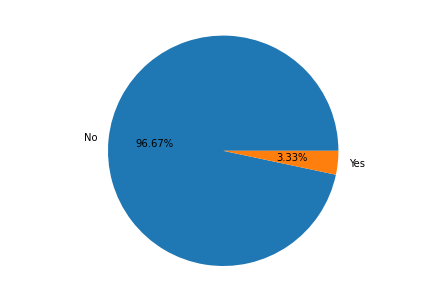

In [49]:
print(results["In DB?"].value_counts())


#Check the ratio of In DB?:Not in DB
in_db_count=results["In DB?"].value_counts()
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(in_db_count,labels=["No","Yes"], autopct='%1.2f%%')
plt.savefig(f"{outdir}/Garnets-In_DB_SP.png")
plt.show()

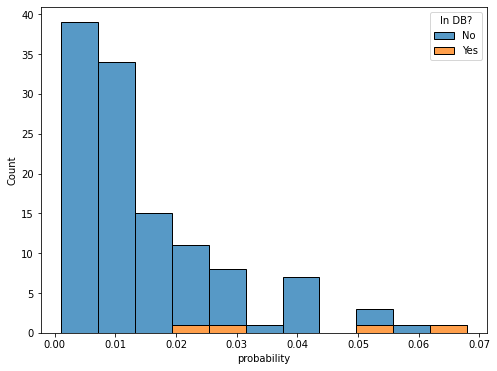

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
ax1=sns.histplot(data=results, x="probability", hue="In DB?",multiple="stack")
#ax2=sns.histplot(new_series, label="New Garnets")
#plt.savefig("Prediction_Probability_Distribution_pym.png")

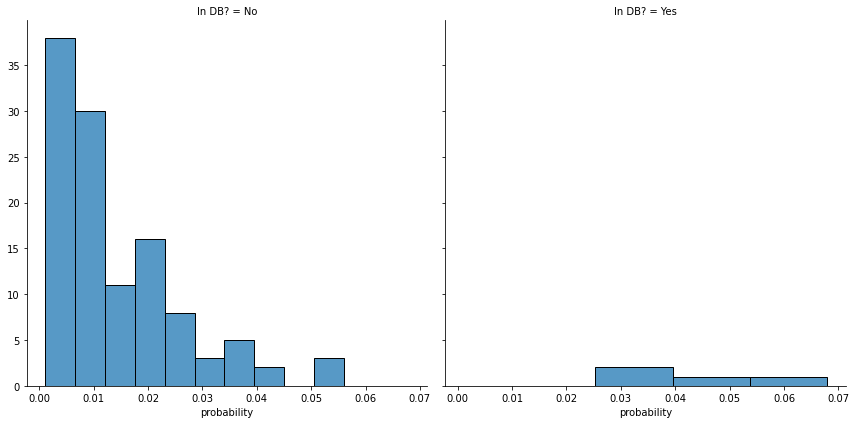

In [51]:

g=sns.FacetGrid(results, col="In DB?", height=6, aspect=1)

g.map(sns.histplot,"probability")
g.savefig(f"{outdir}/Prob_dist.png")

In [52]:
results.head()

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure,In DB?
0,Fe3+,Sn4+,Li1+,O2-,Li7Fe3(SnO6)2,1416.628197,Fe3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.003923,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,No
1,Ti3+,Sn4+,Li1+,O2-,Li7Ti3(SnO6)2,1463.472055,Li1+ O2- Sn4+ Ti3+\n1.0\n-6.634196 6.634196 6....,0.002652,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,No
2,In3+,Sn4+,Li1+,O2-,Li7In3(SnO6)2,1664.338836,In3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.001325,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,No
3,Fe3+,Zr4+,Li1+,O2-,Li7Zr2(FeO4)3,1708.498402,Fe3+ Li1+ O2- Zr4+\n1.0\n-6.525442 6.525442 6....,0.004273,Li7Nd3Zr2O12,Li1+ Nd3+ O2- Zr4+\n1.0\n-6.525442 6.525442 6....,No
4,Co3+,Sn4+,Li1+,O2-,Li7Co3(SnO6)2,1767.400376,Co3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,0.001086,Li7La3(SnO6)2,La3+ Li1+ O2- Sn4+\n1.0\n-6.634196 6.634196 6....,No


In [54]:
#Periodic table BS
#Get element names
from pymatgen.util.plotting import periodic_table_heatmap
A_els=pd.Series([parse_spec(i)[0] for i in results["A"]])
B_els=pd.Series([parse_spec(i)[0] for i in results["B"]])
C_els=pd.Series([parse_spec(i)[0] for i in results["C"]])

#get dict of counts
A_els_counts=A_els.value_counts().to_dict()
B_els_counts=B_els.value_counts().to_dict()
C_els_counts=C_els.value_counts().to_dict()


/home/aonw/anaconda3/envs/structure_prediction_test_env/lib/python3.8/site-packages/pymatgen/util/plotting.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  cbar.cmap.set_under(blank_color)


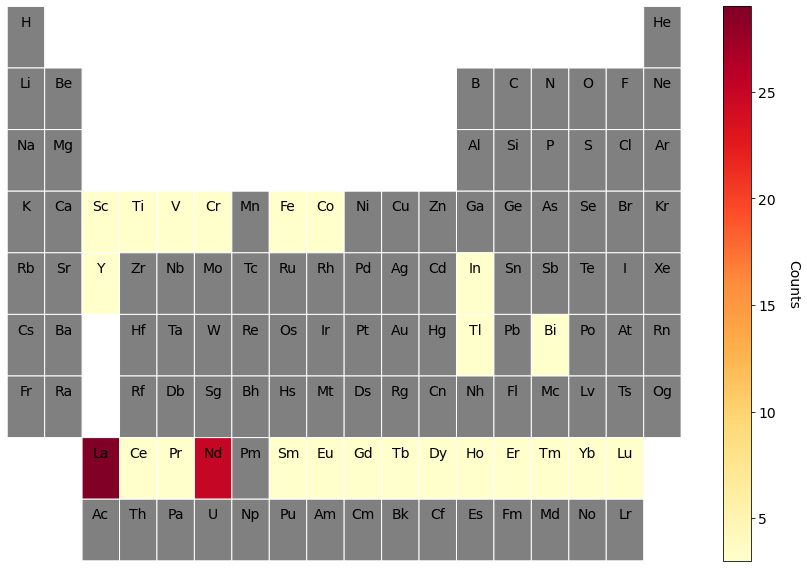

In [55]:
ax1=periodic_table_heatmap(elemental_data=A_els_counts, cbar_label="Counts")
ax1.savefig(f"{outdir}/periodic_table_A.png")


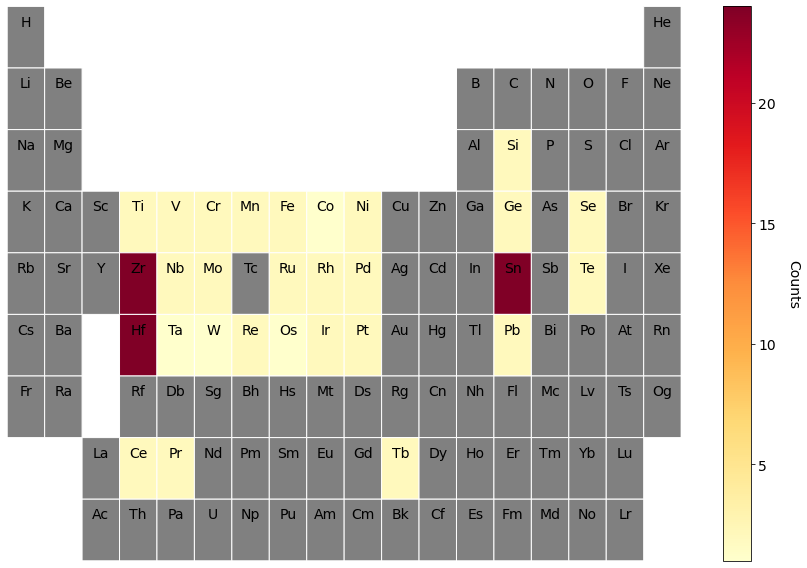

In [56]:
ax2=periodic_table_heatmap(elemental_data=B_els_counts, cbar_label="Counts")
ax2.savefig(f"{outdir}/periodic_table_B.png")

## Interfacing

Let's consider a desire to want to featurise the data for a machine learning algorithm, for example in scikit-learn.

In [26]:
new_data = pd.DataFrame(unique_pretty_formulas).rename(columns={0: 'pretty_formula'})
new_data = new_data.drop_duplicates(subset = 'pretty_formula')
new_data["sus_factor"] = sus_factors
new_data.head()

NameError: name 'unique_pretty_formulas' is not defined

### Sort by sustainability

In [ ]:
new_data=new_data.sort_values(by='sus_factor', ascending=True)
new_data=new_data.reset_index(drop=True)
new_data.head()

In [ ]:
# Use magpie set from matminer plus a couple of others
str_to_comp = StrToComposition(target_col_id='composition_obj')
str_to_comp.featurize_dataframe(new_data, col_id='pretty_formula')

feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), 
                                          cf.IonProperty(fast=True),
                                          cf.BandCenter(), cf.AtomicOrbitals()])

feature_labels = feature_calculators.feature_labels()
feature_calculators.featurize_dataframe(new_data, col_id='composition_obj');

In [ ]:
new_data.head()

In [ ]:
# Save as .csv file 
new_data.to_csv('dataframe_featurized.csv')